In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Import ATL06 Dictionaries

Eventually, I think that we could make this more seamless, where a user simply inserts the name of a line, then our package looks for appropriate cycles and does the velocity calculation all in one. For now, I am just testing everything and leaving it how it is.

In [2]:
# import the atl06 reader
from readers import atl06_to_dict

# read in dictionaries from two different cycles
data_dir = '/Users/benhills/Google Drive File Stream/Shared drives/IceSat2_Surface_Velocity/Shared_Data/FIS_ATL06/'
fn_1 = 'processed_ATL06_20190822153035_08480411_003_01.h5'
D1=atl06_to_dict(data_dir+fn_1,'/gt2l', index=None, epsg=3031)
fn_2 = 'processed_ATL06_20190523195046_08480311_003_01.h5'
D2=atl06_to_dict(data_dir+fn_2,'/gt2l', index=None, epsg=3031)

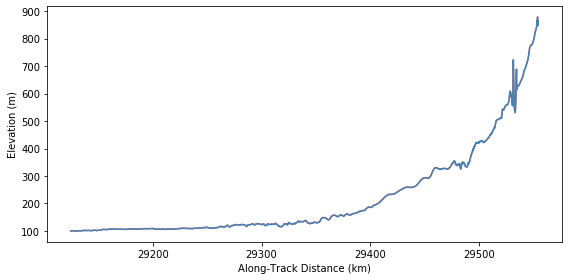

In [3]:
plt.figure(figsize=(8,4))

plt.plot(D1['x_atc']/1000.,D1['h_li'],c='indianred')
plt.plot(D2['x_atc']/1000.,D2['h_li'],c='steelblue')
plt.ylabel('Elevation (m)')
plt.xlabel('Along-Track Distance (km)')

plt.tight_layout()

## Preprocessing - Smooth and Differentiate

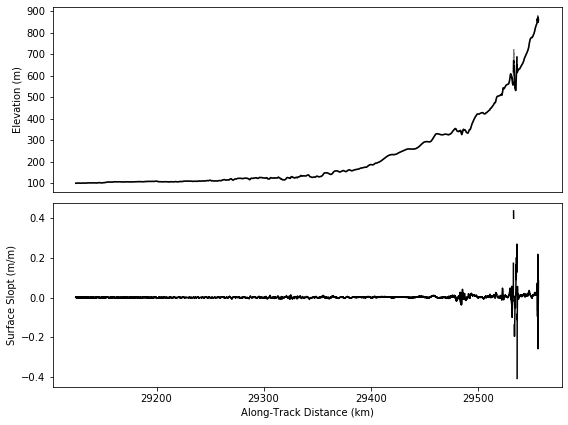

In [4]:
from correlation_processing import smooth_and_diff, fill_seg_ids

x1,h1 = fill_seg_ids(D1['x_atc'],D1['h_li'],D1['segment_id'])
x2,h2 = fill_seg_ids(D2['x_atc'],D2['h_li'],D2['segment_id'])

h1_smooth,dh1 = smooth_and_diff(x1,h1,win=100)
h2_smooth,dh2 = smooth_and_diff(x2,h2,win=100)

# ------------------------------------------

plt.figure(figsize=(8,6))

plt.subplot(211)
plt.tick_params(labelbottom=False,bottom=False)
plt.plot(x1/1000.,h1,c='grey')
plt.plot(x1/1000.,h1_smooth,c='k')
plt.ylabel('Elevation (m)')

plt.subplot(212)
plt.plot(x1/1000.,dh1,c='k')
plt.xlabel('Along-Track Distance (km)')
plt.ylabel('Surface Slopt (m/m)')

plt.tight_layout()

## Velocity Calculation

Lynn did a lot of work here looking for the right search width, segment length, etc. I think that those numbers should be input as defaults into the function eventually, but I couldn't find the optimal numbers that she had. Right now, I have:
- search_width=1000
- segment_length=5000
- dx=20
- corr_threshold=.65

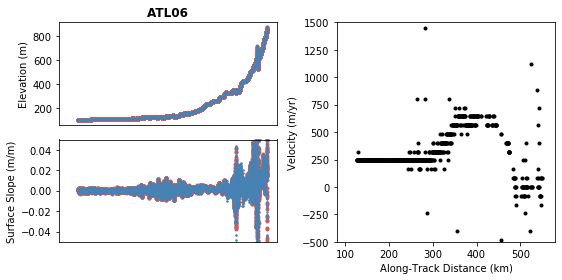

In [5]:
from correlation_processing import velocity, time_diff

dt = time_diff(D1,D2)
vel_xs = np.linspace(np.min(x1)+1000,np.max(x1)-1000,1000)
velocities,correlations = velocity(x1,dh1,dh2,dt,vel_xs,search_width=1000,segment_length=5000)

# ------------------------------------------

from matplotlib.gridspec import GridSpec

plt.figure(figsize=(8,4))
gs = GridSpec(2,2)

plt.subplot(gs[0,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,h1,'.',c='indianred')
plt.plot(x2/1000.-29000,h2,'.',c='steelblue',ms=3)
plt.ylabel('Elevation (m)')
plt.title('ATL06',fontweight='bold')
plt.xlim(80,580)

plt.subplot(gs[1,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,dh1,'.',c='indianred')
plt.plot(x2/1000.-29000,dh2,'.',c='steelblue',ms=3)
plt.ylim(-.05,.05)
plt.ylabel('Surface Slope (m/m)')
plt.xlim(80,580)

ax5 = plt.subplot(gs[:,1])
plt.plot(vel_xs/1000.-29000,velocities,'.',c='k',label='ATL06')
plt.ylabel('Velocity (m/yr)')
plt.xlabel('Along-Track Distance (km)')
plt.xlim(80,580)
plt.ylim(-500,1500)

plt.tight_layout()

## ATL03 Reprocessing

In [ ]:
from readers import read_HDF5_ATL03, get_ATL03_x_atc

atl3_dir = '/Users/benhills/Google Drive File Stream/Shared drives/IceSat2_Surface_Velocity/Shared_Data/FIS_0848_ATL03/ATL03_files/'
fn_1 = atl3_dir + '177516372/ATL03_20190822153035_08480411_003_01.h5'
fn_2 = atl3_dir + '177261775/ATL03_20190523195046_08480311_003_01.h5'

# read the IS2 data with Tyler's ATL03 reader:
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams = read_HDF5_ATL03(fn_1)
# add x_atc to the ATL03 data structure (this function adds to the LS2_ATL03_mds dictionary)
get_ATL03_x_atc(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)
#-- select the 2l beam from ATL03
D3 = IS2_atl03_mds['gt2l']
LMH=D3['heights']['signal_conf_ph'][:,3] >= 2
x3_1 = D3['heights']['x_atc'][LMH]
h3_1 = D3['heights']['h_ph'][LMH]

# read the IS2 data with Tyler's ATL03 reader:
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams = read_HDF5_ATL03(fn_2)
# add x_atc to the ATL03 data structure (this function adds to the LS2_ATL03_mds dictionary)
get_ATL03_x_atc(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)
#-- select the 2l beam from ATL03
D3 = IS2_atl03_mds['gt2l']
LMH=D3['heights']['signal_conf_ph'][:,3] >= 2
x3_2 = D3['heights']['x_atc'][LMH]
h3_2 = D3['heights']['h_ph'][LMH]

In [ ]:
from atl03_reprocessing import reinterpolate_atl03

h3_1 = h3_1[np.logical_and(x3_1>np.nanmin(D1['x_atc']),x3_1<np.nanmax(D1['x_atc']))]
x3_1 = x3_1[np.logical_and(x3_1>np.nanmin(D1['x_atc']),x3_1<np.nanmax(D1['x_atc']))]
h3_2 = h3_2[np.logical_and(x3_2>np.nanmin(D2['x_atc']),x3_2<np.nanmax(D2['x_atc']))]
x3_2 = x3_2[np.logical_and(x3_2>np.nanmin(D2['x_atc']),x3_2<np.nanmax(D2['x_atc']))]

#!!!!!!!!!!!!!!!!!!! This takes forever, instead of reprocessing just reload the numpy arrays in the next cell
"""
x_3_1,h_3_1 = reinterpolate_atl03(x3_1,h3_1)
x_3_2,h_3_2 = reinterpolate_atl03(x3_2,h3_2)

np.save('../data/reinterpret_atl03_file1.npy',np.array([x_3_1,h_3_1]))
np.save('../data/reinterpret_atl03_file2.npy',np.array([x_3_2,h_3_2]))
"""

In [ ]:
atl3_dir = '/Users/benhills/Google Drive File Stream/Shared drives/IceSat2_Surface_Velocity/Shared_Data/FIS_0848_ATL03/reinterpolated/'
x1,h1 = np.load(atl3_dir+'reinterpolated_atl03_file1.npy')
x2,h2 = np.load(atl3_dir+'reinterpolated_atl03_file2.npy')

h1_smooth,dh1 = smooth_and_diff(x1,h1,win=100)
h2_smooth,dh2 = smooth_and_diff(x2,h2,win=100)

vel_xs = np.linspace(np.min(x1)+1000,np.max(x1)-1000,1000)
velocities,correlations = velocity(x1,dh1,dh2,dt,vel_xs,search_width=1000,segment_length=5000,dx=5)

# ------------------------------------------

plt.figure(figsize=(8,4))
gs = GridSpec(2,2)

plt.subplot(gs[0,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,h1,'.',c='indianred')
plt.plot(x2/1000.-29000,h2,'.',c='steelblue',ms=3)
plt.ylabel('Elevation (m)')
plt.title('ATL03',fontweight='bold')
plt.xlim(80,580)

plt.subplot(gs[1,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,dh1,'.',c='indianred')
plt.plot(x2/1000.-29000,dh2,'.',c='steelblue',ms=3)
plt.ylim(-.05,.05)
plt.ylabel('Surface Slope (m/m)')
plt.xlim(80,580)

ax5 = plt.subplot(gs[:,1])
plt.plot(vel_xs/1000.-29000,velocities,'.',c='c',mfc='w',label='ATL06')
plt.ylabel('Velocity (m/yr)')
plt.xlabel('Along-Track Distance (km)')
plt.xlim(80,580)
plt.ylim(-500,1500)

plt.tight_layout()

## Error Estimation

Trevor and Canyon have taken the lead on this so far. The cells below are taken directly from a notebook that was in Trevor's directory

In [ ]:
x = np.arange(-np.pi*12, np.pi*12,0.01)
noise = np.random.normal(0, .01, len(x))
y1 = np.sin(x)
y2 = np.sin(1.1*x)

fig, ax = plt.subplots(1,1)
ax.plot(x, y1, c='c', linewidth=4)
ax.plot(x, y2, c='k', linestyle='dashed')
plt.show()

In [ ]:
# 1) Find  all local minima an maxima in y1 and y2
# First find all zeros
y_indices = np.arange(0,len(y1))
zeros1 = np.zeros(np.shape(y1), dtype=bool)
zeros2 = np.zeros(np.shape(y2), dtype=bool)
for index in np.arange(0, len(y1)-1):
    if np.sign(y1[index]) != np.sign(y1[index+1]):
        zeros1[index] = True
        
    if np.sign(y2[index]) != np.sign(y2[index+1]):
        zeros2[index] = True

# calculate offset between local minima and maxima
zeros1Indices = y_indices[zeros1]
offsetsMax = np.zeros(np.sum(zeros1),)
offsetsMin = np.zeros(np.sum(zeros1),)
x_y1Max = np.zeros(np.sum(zeros1),)
x_y1Min = np.zeros(np.sum(zeros1),)
x_y2Max = np.zeros(np.sum(zeros1),)
x_y2Min = np.zeros(np.sum(zeros1),) 

for index in np.arange(0, np.sum(zeros1)-1):
    startInd = zeros1Indices[index]
    endInd = zeros1Indices[index+1]
    x_y1Max[index] = x[y1 == np.max(y1[startInd:endInd])] #find x-position of y1 max
    x_y1Min[index] = x[y1 == np.min(y1[startInd:endInd])] #"" y1 min
    
    x_y2Max[index] = x[y2 == np.max(y2[startInd:endInd])] #find x-position of y2 max
    x_y2Min[index] = x[y2 == np.min(y2[startInd:endInd])] # "" y2 min
    
offsetsMax = x_y1Max - x_y2Max
offsetsMin = x_y1Min - x_y2Min
offsets = np.asarray([offsetsMax,offsetsMin])
    # What happens if there are not the same number of mins and maxs between y1 and y2?
    # Perhaps it is better to create a pdf or cdf of the slopes?
# calculate standard deviation and RMSE from those offsets
#for ii in np.arange(0, len(y1)-1):
    

In [ ]:
RMSE = np.sqrt( np.sum(offsets**2) / len(offsets) )
print("Root mean square error = {:.2f}".format(RMSE))

"""
Next we need to propagate this through to the velocity
Other sources of uncertainty to consider:
Signal-to-noise ratio (how much does ATL06 look like ATL03?) 
Resolution threshold: X-correlation precision is limited by resolution of ATL06 
(or product of our own reprocessing)
"""

## Extract Along-Track from Velocity Field

Lynn, Rodrigo, and Grace had most of the scripts on this. Eventually, this should be moved into .py scripts, but I haven't had the chance to do that yet.

In [ ]:
import os,re,h5py
import requests
import zipfile

import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import scipy, sys, os, pyproj, glob
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import pointCollection as pc
import math

# Import some of the scripts that we have written
import sys
sys.path.append("/home/jovyan/surface_velocity/scripts")
from loading_scripts import atl06_to_dict

# run matplotlib in 'widget' mode
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [ ]:
#From Ben Smith's code loading in .tif file, running into issues likely with directories
data_root='/srv/shared/surface_velocity/FIS_Velocity/'
#spatial_extent = np.array([-102, -76, -98, -74.5])
spatial_extent = np.array([-65, -86, -55, -81])
lat=spatial_extent[[1, 3, 3, 1, 1]]
lon=spatial_extent[[2, 2, 0, 0, 2]]
print(lat)
print(lon)
# project the coordinates to Antarctic polar stereographic
xy=np.array(pyproj.Proj(3031)(lon, lat))
# get the bounds of the projected coordinates 
XR=[np.nanmin(xy[0,:]), np.nanmax(xy[0,:])]
YR=[np.nanmin(xy[1,:]), np.nanmax(xy[1,:])]
#Originally tried to load data from a local directory, should change to shared directory
Measures_vx=pc.grid.data().from_geotif(os.path.join(data_root,'Measures2_FIS_Vx.tif'), bounds=[XR, YR])
Measures_vy=pc.grid.data().from_geotif(os.path.join(data_root,'Measures2_FIS_Vy.tif'), bounds=[XR, YR])

In [ ]:
# Load a line and plot

data_root='/srv/shared/surface_velocity/'
field_dict={None:['delta_time','latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}

rgt = "0848"
#rgt = "0537"
cycle="04"
filename = glob.glob(os.path.join(data_root, 'FIS_ATL06', f'*ATL06_*_{rgt}{cycle}*_003*.h5'))[0]

D=atl06_to_dict(filename,'/gt3r', field_dict=field_dict, index=None, epsg=3031)



In [ ]:
# show the velocity maps:
plt.figure(figsize=(8,4))
plt.subplot(121)
Measures_vx.show(cmap='viridis', clim=[-100,100])
plt.plot(xy[0,:], xy[1,:],'k')
plt.title('Measures X-Velocity')
plt.plot(D['x'],D['y'],'r')
plt.gca().set_aspect('equal')

plt.subplot(122)
Measures_vy.show(cmap='viridis', clim=[-100,100])
plt.plot(xy[0,:], xy[1,:],'k')
plt.title('Measures Y-Velocity')
plt.plot(D['x'],D['y'],'r')
plt.gca().set_aspect('equal')

#plt.tight_layout()

In [ ]:
vx = Measures_vx.interp(D['x'],D['y'])
vy = Measures_vy.interp(D['x'],D['y'])

#Solve for angle to rotate Vy to be along track and Vx to be across track
import math
xL=abs((D['x'][0])-(D['x'][1]))
yL=abs((D['y'][0])-(D['y'][1]))

#decides if is descending or ascending path
if D['x'][0]-D['x'][1] < 0:

    theta_rad=math.atan(xL/yL)
    #theta_deg=theta_rad*180/math.pi
    v_along=vy/math.cos(theta_rad)
    v_across=vx/math.cos(theta_rad)

else:
    
    theta_rad=math.atan(xL/yL)
    #theta_deg=theta_rad*180/math.pi
    v_along=vy/math.sin(theta_rad)
    v_across=vx/math.sin(theta_rad)

plt.figure(figsize=(8,4))
plt.subplot(221)
plt.plot(D['x_atc'],vx)
plt.title('MEaSUREs Vx')
plt.subplot(222)
plt.plot(D['x_atc'],vy)
plt.title('MEaSUREs Vy')
plt.subplot(223)
plt.plot(D['x_atc'],v_along)
plt.title('V_along')
plt.subplot(224)
plt.plot(D['x_atc'],v_across)
plt.title('V_across')
plt.tight_layout()

#plt.figure(figsize=(8,4))
#plt.subplot(121)
#plt.plot(D['x_atc'],v_along)
#plt.title('V_along')
#plt.subplot(122)
#plt.plot(D['x_atc'],v_across)
#plt.title('V_across')

# Double check Velocities, v_along should be similar to vy but should major differences where flow angle changes
Vdiff=vy-v_along


plt.figure(figsize=(4,4))
plt.plot(D['x_atc'],Vdiff)
plt.title('Difference between Vy and Valong')

plt.tight_layout()

np.save(('/home/jovyan/surface_velocity/contributors/joseph_martin/v_along%s.npy' % rgt), v_along)
np.save(('/home/jovyan/surface_velocity/contributors/joseph_martin/v_across%s.npy' % rgt), v_across)
np.save(('/home/jovyan/surface_velocity/contributors/joseph_martin/x_atc%s.npy' % rgt), D['x_atc'])

#load rotated velocities into dictionary
#D['v_along']=v_along

## Removing Static Topography

This is taken from what Trevor and Grace had done. I haven't changed anything...

In [ ]:
import h5py
import os
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import NearestNDInterpolator
from utils import transform_coord
from utils import make_grid
from utils import mad_std
from utils import spatial_filter
from utils import interp2d
from utils import tiffread
from utils import binning
from scipy.ndimage.filters import generic_filter
from shutil import copyfile
import re
import pyproj
%matplotlib inline

In [ ]:
datapath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small/'
outputPath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small_demeaned/'

In [ ]:
#!python readatl06.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small/*.h5 -o /home/jovyan/shared/surface_velocity/FIS_processed_ATL06 -n 8

#!python merge.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small_processed/*D.h5 -o /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_D.h5

#!python fittopo.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_D.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 \
#-k 2 -t 2020 -j 3031 -v lon lat t_year h_elv -s 10 -p

#!python fittopo.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_A.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 \
#-k 2 -t 2020 -j 3031 -v lon lat t_year h_elv -s 10 -p

##Merge the files.
#NB: For some reason, FIS_ATL06_D_TOPO.h5 does not have s_elv. What is that field?
#!python merge.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_?_TOPO.h5 -o /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_AD.h5

!h5ls /home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20190531193406_09700311_003_01.h5

In [ ]:
FIS_data = h5py.File('/home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_AD.h5','r')

print(FIS_data["cycle"][:])

In [ ]:
with h5py.File('/home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_AD.h5','r') as f_r:
    lat   = f_r['lat'][:]
    lon   = f_r['lon'][:]
    t_yrs = f_r['t_year'][:]
    h_res = f_r['h_res'][:]
    h_mod = f_r['h_mod'][:] # <---This is the static surface
    h_org = f_r['h_elv'][:]

In [ ]:
fig,ax = plt.subplots(ncols=3, figsize=(20,20), subplot_kw={'projection':ccrs.SouthPolarStereo()})

FIS_origSurfPlot = ax[0].scatter(lon[::100], lat[::100], s=3, c=h_org[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='magma')
cax0,kw0 = matplotlib.colorbar.make_axes(ax[0],location='right',pad=0.05,shrink=0.25, label='Measured surf elev (m)')
resCBar=fig.colorbar(FIS_origSurfPlot,cax=cax0,extend='both',**kw0)
ax[0].coastlines('50m')

FIS_statSurfPlot = ax[1].scatter(lon[::100], lat[::100], s=3, c=h_mod[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='magma')
cax1,kw1 = matplotlib.colorbar.make_axes(ax[1],location='right',pad=0.05,shrink=0.25, label='Static surf elev (m)')
statCBar=fig.colorbar(FIS_statSurfPlot,cax=cax1,extend='both',**kw1)
ax[1].coastlines('50m')

FIS_resSurfPlot = ax[2].scatter(lon[::100], lat[::100], s=3, c=h_res[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='coolwarm_r')
cax2,kw2 = matplotlib.colorbar.make_axes(ax[2],location='right',pad=0.05,shrink=0.25, label='Res surf elev (m)')
resCBar=fig.colorbar(FIS_resSurfPlot,cax=cax2,extend='both',**kw2)
ax[2].coastlines('50m')

plt.show()

In [ ]:
fig = plt.hist(h_res[~np.isnan(h_res)], 100, edgecolor='k')
plt.xlabel('Residuals (m)')
print('Mean:', np.around(100*np.nanmean(h_res),3), 'cm')
print('Std.dev:',np.around(100*np.nanstd(h_res),3), 'cm')
print('Rejected:', np.around(100*(float(len(h_res[np.isnan(h_res)]))/len(h_res)),2), '%')

In [ ]:
staticSurfInterpolator = NearestNDInterpolator(np.vstack((lon, lat)).T, h_mod) # interpolator function

In [ ]:
beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r'] # loop through each beam
for file in os.listdir(datapath):
    print("Subtracting static surface from tracks in {}".format(file))
    destFile = file.replace('processed', 'demeaned')
    copyfile(datapath+'/'+file, outputPath+'/'+destFile) #make a copy of the file to append to in outputPath directory
    for beam in beams:
        try:
            print("Processing beam {}".format(beam))
            with h5py.File(datapath + '/' + file, 'r') as sourceFile:
                beamLat = sourceFile[beam+'/land_ice_segments/latitude'][:]
                beamLon = sourceFile[beam+'/land_ice_segments/longitude'][:]
                h_li_statSurf = staticSurfInterpolator(np.vstack((beamLon,beamLat)).T)
                h_li_res = sourceFile[beam+'/land_ice_segments/h_li'][:]- h_li_statSurf
            
            with h5py.File(outputPath + '/' + destFile, 'a') as demeanedFile:
                demeanedFile[beam+'/h_li_res'] = h_li_res
                demeanedFile[beam+'/h_li_statSurf'] = h_li_statSurf
        except:
            print("Data not found for beam {}. Skipping".format(beam))

In [ ]:
fig, ax = plt.subplots(6,1, figsize=(20,20))
beamCount=0
plotFilePath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small_demeaned/demeaned_ATL06_20191206000243_10700511_003_01.h5'

with h5py.File(plotFilePath, 'r') as afile:
    for beam in beams:
        h_li_res = afile[beam+'/h_li_res'][:]
        x_atc = afile[beam+'/land_ice_segments/ground_track/x_atc/'][:]
        ax[beamCount].plot(x_atc, h_li_res)
        beamCount += 1
        
        
plt.show()